# What are CNN Blocks? Why Are They Used?

CNN (Convolutional Neural Network) blocks are pre-designed, reusable modules that consist of a combination of layers such as convolutional layers, activation functions, normalization layers, and pooling layers. These blocks can be stacked together to form a complete CNN architecture.

Essentially - they are reusable components in convolutional neural networks (CNNs) that repeat one or more times to form the overall network architecture.

Some common examples of layers used in CNN blocks are include:
- Convolutional layers (With stride, without stride, depthwise/pointwise, etc)
- Pooling layers (Max Pooling, Mean/Avg Pooling, etc)
- BatchNorm/LayerNorm Layers
- Activation Functions (GELU, ReLU, etc)

Common examples of CNN blocks:
- Residual blocks
- ResNet Basic Blocks
- ResNet Bottleneck blocks
- Depthwise separable convolution blocks

CNN blocks are used to simplify network design and improve performance. The key advantages of using blocks include:

- Modularity: Blocks are modular and can be combined in different ways like lego pieces. This makes designing networks flexible.
- Reuse: Blocks like ResNet blocks are reused across different datasets and tasks once designed. This saves engineering effort.
- Interpretable Design:  Blocks often encapsulate a specific design philosophy or operation, making the architecture easier to understand.
- Regularization: Repeating blocks with the same structure acts as a regularization, preventing overfitting.
- Parameter Efficiency: Blocks can be designed to use fewer parameters while maintaining performance.

Overall, using repeatable blocks makes CNN design more systematic compared to designing one monolithic network.



In [ ]:
import torch
import torch.nn as nn

class SimpleCNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(SimpleCNNBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

## What Are Residual Connections?
Residual connections are a type of shortcut connection that skips one or more layers during the forward and backward passes. The main idea is to add the original input $x$ to the output $F(x)$ of the block, making the output $F(x)+x$.

### Why?

**Vanishing/Exploding Gradients:** Mitigates the problem, enabling deeper networks.
**Training Speed:** Helps faster convergence during training.
**Representation Power:** Helps the model to learn more complex functions.


The key ideas behind ResNet are:

- Use residual connections that bypass a few layers and add back the input to the output.
- Stack residual blocks one after the other to build very deep networks.
- Use "bottleneck" blocks with 1x1 convolutions to reduce computation.

The core building block is a residual unit that learns a residual function $F(x)$ and adds it to the input $x$ : $y = F(x) + x$


The residual blocks are shown below:

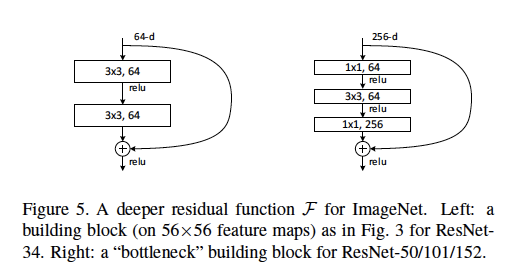


Here's how you can code a basic ResNet block in PyTorch:

In [ ]:
# Basic ResNet Block
import torch.nn.functional as F
class BasicBlock(nn.Module):
    """
    # ResNet Basic Block Structure
    #
    # Input -> Conv3x3 -> BN -> ReLU -> Conv3x3 -> BN -> ReLU -> Output
    #      \_______________________________________________________/ (Residual Connection)
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y += self.shortcut(x)
        y = F.relu(y)
        return y


# Bottleneck Block
class Bottleneck(nn.Module):
    """
    # ResNet Bottleneck Block Structure
    #
    # Input -> Conv1x1 -> BN -> ReLU -> Conv3x3 -> BN -> ReLU -> Conv1x1 -> BN -> ReLU -> Output
    #      \______________________________________________________________________________/ (Residual Connection)
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        mid_channels = out_channels // 4

        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)

        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(y)))
        y = self.bn3(self.conv3(y))
        y += self.shortcut(x)
        y = F.relu(y)
        return y

In both Basic and Bottleneck blocks, if the input and output dimensions don't match, a convolutional layer is added to the shortcut to ensure that its output can be added to the main path's output. This is conditional on stride and the number of input/output channels.

## Depthwise and Pointwise Convolutions

Depthwise convolutions apply a single convolutional filter per input channel. Pointwise convolutions are 1x1 convolutions that combine the depthwise output channels.

Depthwise separable convolutions split a standard convolution into depthwise + pointwise parts. The computation savings come from:

Depthwise convs have only #channels * k * k params vs Traditional convolutions that have #channels * #filters * k * k params

Pointwise convs have #channels * #filters params but are fast 1x1 convs.

So depthwise + pointwise is more efficient than standard convs.

For example, for a 64 channel, 256 filter 3x3 conv, we get:

- Standard conv: 64 * 256 * 3 * 3 = 1,474,560 params
- Depthwise conv: 64 * 3 * 3 = 576 params (channels are separated)
- Pointwise conv: 64 * 256 = 16,384 params (fast 1x1)

Total: 576 + 16,384 = 16,960 params -> 9x fewer params than standard!

This reduces computations while maintaining accuracy in many cases. Depthwise separable convolutions are used in models like Xception and MobileNets and ConvNeXt.

In [ ]:
### Depthwise separable convolution
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x):
        y = self.depthwise(x)
        y = self.pointwise(y)
        return y

## Exercise

Read the ConVneXt Paper - https://arxiv.org/pdf/2201.03545.pdf


Implement a ConVneXt Block given below. You can use the following for reference

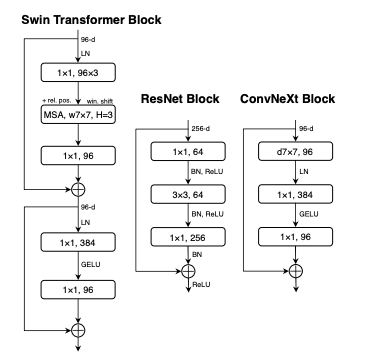

In [ ]:
import torch
import torch.nn as nn

class ConvNeXtBlock(nn.Module):

    def __init__(self, dim, drop_path_rate=0.):
        super().__init__()
        self.dim = dim
        self.drop_path_rate = drop_path_rate

        # TODO: Initialize a norm layer, for example nn.LayerNorm
        self.norm = None

        # TODO: Initialize a depthwise convolution layer (groups=?)
        self.depthwise_conv = None

        # TODO: Initialize a gelu activation layer
        self.gelu = None

        # TODO: Initialize a pointwise convolution layer (Filter size?)
        self.pointwise_conv = None

        # TODO: Initialize a dropout layer
        self.dropout = None

    def forward(self, x):
        # TODO: Normalize the input
        x = None

        # TODO: Apply depthwise convolution
        x = None

        # TODO: Apply activation
        x = None

        # TODO: Apply dropout
        x = None

        # TODO: Apply pointwise convolution
        x = None

        # TODO: Apply stochastic depth -> can use from pytorch - https://pytorch.org/vision/main/generated/torchvision.ops.stochastic_depth.html
        x = None

        return x

# Example usage:
block = ConvNeXtBlock(dim=128)
x = torch.rand(1, 128, 56, 56)
y = block(x)
print(y.shape) # torch.Size([1, 128, 56, 56])